In [1]:
pip install pandas scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [61]:
pip install matplotlib seaborn wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 34.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [62]:
import polars as pl
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [3]:
pl.Config.set_thousands_separator(",")
pl.Config.set_tbl_hide_column_data_types(True)
pl.Config.set_float_precision(3)
pl.Config.set_tbl_rows(20)

polars.config.Config

In [4]:
!wget -nc https://ling583.s3.amazonaws.com/books.parquet

File ‘books.parquet’ already there; not retrieving.



In [12]:
c = pl.read_parquet('books.parquet')

In [13]:
print(type(c))

<class 'polars.dataframe.frame.DataFrame'>


In [14]:
c.head()

tok,norm,tag,pos,fileid,sentid
"""[""","""[""","""XX""","""X""","""austen-emma""","""austen-emma_0000"""
"""Emma""","""emma""","""NNP""","""PROPN""","""austen-emma""","""austen-emma_0000"""
"""by""","""by""","""IN""","""ADP""","""austen-emma""","""austen-emma_0000"""
"""Jane""","""jane""","""NNP""","""PROPN""","""austen-emma""","""austen-emma_0000"""
"""Austen""","""austen""","""NNP""","""PROPN""","""austen-emma""","""austen-emma_0000"""


In [15]:
c.shape

(1439763, 6)

In [16]:
c.columns

['tok', 'norm', 'tag', 'pos', 'fileid', 'sentid']

In [17]:
c = pd.read_csv('books.csv')

# NGRAMS

## Purpose: 
To generate and analyze sequences of n consecutive items (tokens or characters) from the text, enabling text pattern recognition and frequency analysis.




## Functions:
#### generate_ngrams: Creates n-grams from a tokenized list.
#### compute_ngrams: Groups tokens by fileid and generates n-grams at either token or character level.

## Steps:
Tokenize the text into smaller units (tokens or characters).
Generate n-grams from these units.
Count and analyze the frequency of n-grams across the text.

## Visualization:
Bar chart and word cloud are used to display the most frequent n-grams.

In [20]:
def generate_ngrams(tokens, n):
    return [' '.join(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

In [21]:
def compute_ngrams(df, n, level='token'):
    if level == 'token':
            grouped = df.group_by('fileid').agg(pl.col('norm').list().alias('tokens'))
        elif level == 'character':
            grouped = df.group_by('fileid').agg(pl.col('tok').apply(lambda x: list(''.join(x))).alias('tokens'))
        else:
            raise ValueError(f"Invalid level: {level}. Valid levels are 'token' and 'character'.")
    
        return grouped.with_column(pl.col('tokens').apply(generate_ngrams, n=n).alias('ngrams')) 

In [23]:
ngrams = compute_ngrams(c, 3, level='token')

In [24]:
print(ngrams)

fileid
austen-em                                                     []
austen-emma    [[ emma by, emma by jane, by jane austen, jane...
Name: norm, dtype: object


In [53]:
all_ngrams = [ngram for ngrams_list in c['norm'] for ngram in ngrams_list]

In [57]:
print(len(all_ngrams))

589072


In [63]:
ngram_counts = Counter(all_ngrams)

ngram_df = pl.DataFrame({
    "ngram": list(ngram_counts.keys()),
    "count": list(ngram_counts.values())
})

ngram_df = ngram_df.sort("count", descending=True)

In [64]:
ngram_df.head() 

,ngram,count
1,e,69853
10,t,48325
3,a,44740
16,o,43697
7,n,38653


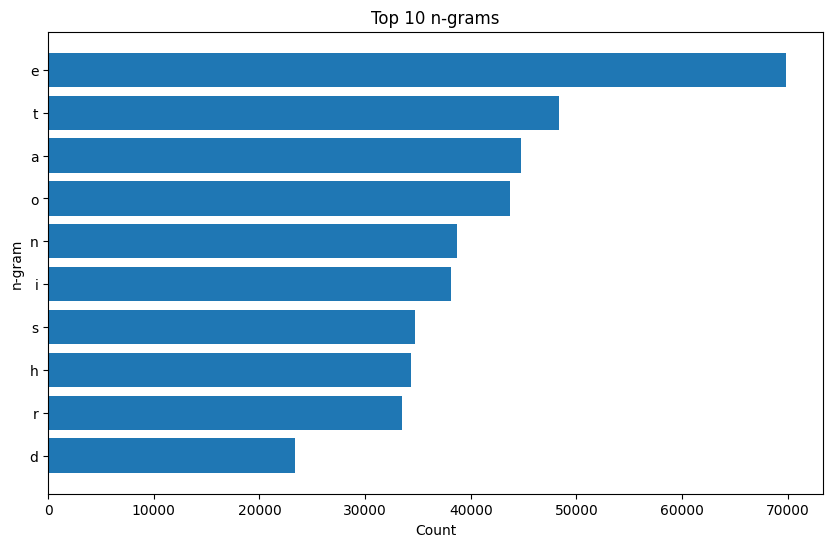

In [65]:
# Step 3: Bar Chart of Top N n-grams
top_n = 10
plt.figure(figsize=(10, 6))
plt.barh(ngram_df['ngram'].head(top_n), ngram_df['count'].head(top_n))
plt.xlabel('Count')
plt.ylabel('n-gram')
plt.title(f'Top {top_n} n-grams')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()


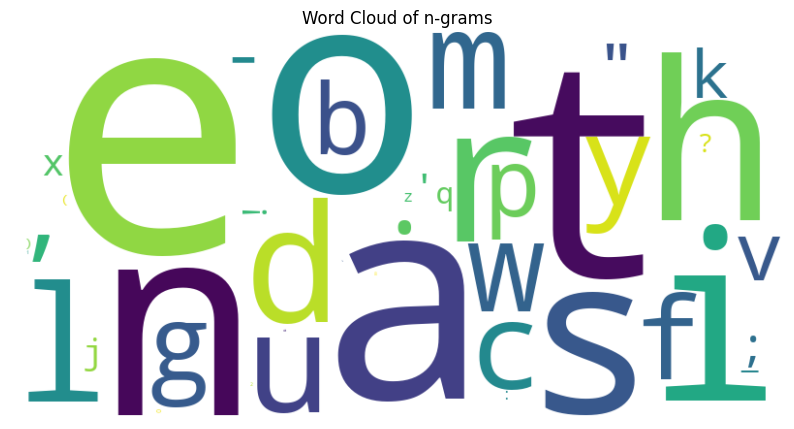

In [66]:
# Step 4: Word Cloud of n-grams
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(ngram_counts)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of n-grams')
plt.show()


# BURROWS'S DELTA

## Purpose: 
A statistical measure for comparing the stylistic similarities between different texts.


## Functions:
#### relative_frequency: Computes the relative frequency of each word in a text.
#### burrows_delta: Calculates the mean difference in relative frequency between texts for shared words.

## Steps:
Compute the relative frequency of terms within each text.
Find the mean frequency of each term across all texts.
Calculate the absolute difference (delta) for each term and average it for each text.

## Visualization: 
A bar chart showing Burrows's Delta values for each text file.

In [25]:
def relative_frequency(df):
    freq = (
        df.group_by(['fileid', 'norm'])
          .agg(pl.count().alias('count'))  # Equivalent to .size()
    )
    
    # Calculate total count for each 'fileid'
    total_counts = (
        freq.group_by('fileid')
            .agg(pl.col('count').sum().alias('total_count'))
    )
    
    # Join to calculate relative frequency
    rel_freq = (
        freq.join(total_counts, on='fileid')
            .with_column((pl.col('count') / pl.col('total_count')).alias('relative_frequency'))
            .select(['fileid', 'norm', 'relative_frequency'])  # Select relevant columns
    )
    return rel_freq

In [45]:
def burrows_delta(df):
    rel_freq = relative_frequency(df)
    if rel_freq.is_empty():
        return pl.DataFrame({"fileid": [], "burrows_delta": []})

    mean_freq = (
        rel_freq.group_by("norm")
        .agg(pl.col("relative_frequency").mean().alias("mean_frequency"))
    )

    delta = (
        rel_freq.join(mean_freq, on="norm")
        .with_column(
            (pl.col("relative_frequency") - pl.col("mean_frequency"))
            .abs()
            .alias("delta")
        )
    )

    burrows_delta = (
        delta.group_by("fileid")
        .agg(pl.col("delta").mean().alias("burrows_delta"))
    )
    return burrows_delta 


In [46]:
burrows_result = burrows_delta(c)

In [47]:
print(burrows_result)

fileid
austen-em      0.486531
austen-emma    0.000062
dtype: float64


In [67]:
def visualize_burrows_delta(delta):
    plt.figure(figsize=(10, 6))
    delta.plot(kind='bar', color='teal', alpha=0.7)
    plt.title('Burrows’s Delta Across Texts')
    plt.xlabel('File ID')
    plt.ylabel('Delta Value')
    plt.xticks(rotation=45, ha='right')
    plt.show()

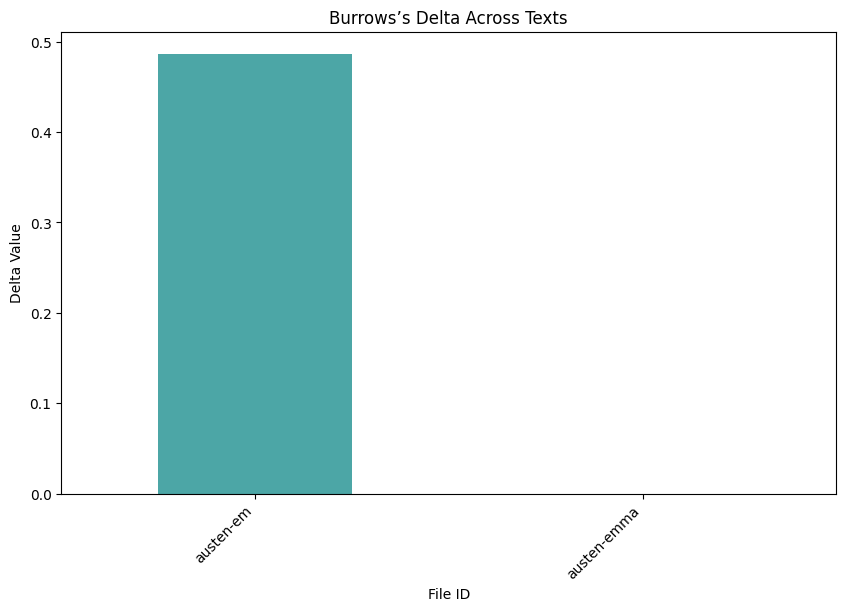

In [68]:
visualize_burrows_delta(burrows_result)

# CRAIGS ZETA

## Purpose: 
Identifies words or features significantly more frequent in one group of texts compared to another.


## Functions:
#### craigs_zeta and craigs_zeta2: Compute the proportion of a word in one group relative to the total proportions in both groups.

## Steps:
Split texts into two groups based on fileid.
Compute word frequencies and their proportions in each group.
Calculate zeta values indicating the likelihood of a term being specific to one group.

## Visualization: 
Bar charts and histograms display zeta values for different terms.

In [72]:
def craigs_zeta(df, feature='norm'):
    group_a_filter = "austen-emma"
    
    # Step 1: Split the dataset into two groups
    group_a = df.filter(pl.col("fileid") == group_a_filter)
    group_b = df.filter(pl.col("fileid") != group_a_filter)

    # Count frequencies for the given feature
    freq_a = group_a.group_by(feature).agg(pl.count().alias("freq_a"))
    freq_b = group_b.group_by(feature).agg(pl.count().alias("freq_b"))

    total_a = freq_a.select(pl.col("freq_a").sum()).item()  
    total_b = freq_b.select(pl.col("freq_b").sum()).item() 

    prop_a = freq_a.with_column((pl.col("freq_a") / total_a).alias("prop_a"))
    prop_b = freq_b.with_column((pl.col("freq_b") / total_b).alias("prop_b"))
    
    combined = prop_a.join(prop_b, on=feature, how="outer").fill_null(0)
    zeta = combined.with_column(
        (pl.col("prop_a") / (pl.col("prop_a") + pl.col("prop_b")))
    )

    return zeta


In [81]:
def craigs_zeta2(df, feature='norm'):
    group_a_filter = "austen-em"
    
    # Step 1: Split the dataset into two groups
    group_a = df.filter(pl.col("fileid") == group_a_filter)
    group_b = df.filter(pl.col("fileid") != group_a_filter)

    # Count frequencies for the given feature
    freq_a = group_a.group_by(feature).agg(pl.count().alias("freq_a"))
    freq_b = group_b.group_by(feature).agg(pl.count().alias("freq_b"))

    total_a = freq_a.select(pl.col("freq_a").sum()).item()  
    total_b = freq_b.select(pl.col("freq_b").sum()).item() 

    prop_a = freq_a.with_column((pl.col("freq_a") / total_a).alias("prop_a"))
    prop_b = freq_b.with_column((pl.col("freq_b") / total_b).alias("prop_b"))
    
    combined = prop_a.join(prop_b, on=feature, how="outer").fill_null(0)
    zeta = combined.with_column(
        (pl.col("prop_a") / (pl.col("prop_a") + pl.col("prop_b")))
    )

    return zeta


In [73]:
zeta_result = craigs_zeta(c) 

In [82]:
zeta_result2 = craigs_zeta2(c) 

In [74]:
print(zeta_result) 

norm
!            0.0
"            0.0
"--          0.0
"--ford      0.0
"--mrs       0.0
            ... 
youth        0.0
youthful     0.0
zeal         0.0
zeal!--it    0.0
zigzags      0.0
Length: 7785, dtype: float64


In [83]:
print(zeta_result2) 

norm
!            0.0
"            0.0
"--          0.0
"--ford      0.0
"--mrs       0.0
            ... 
youth        0.0
youthful     0.0
zeal         0.0
zeal!--it    0.0
zigzags      0.0
Length: 7785, dtype: float64


In [75]:
zeta_result = zeta_result.sort(descending=True)
print(zeta_result)

norm
the             0.026232
pocket!--one    0.000000
pocket          0.000000
plump           0.000000
plot            0.000000
                  ...   
far             0.000000
fancying        0.000000
fancy           0.000000
fancifulness    0.000000
fast            0.000000
Length: 7785, dtype: float64


In [84]:
zeta_result2 = zeta_result2.sort(descending=True)
print(zeta_result2)

norm
the             0.973768
pocket!--one    0.000000
pocket          0.000000
plump           0.000000
plot            0.000000
                  ...   
far             0.000000
fancying        0.000000
fancy           0.000000
fancifulness    0.000000
fast            0.000000
Length: 7785, dtype: float64


In [85]:
print(zeta_result.describe())
print(zeta_result2.describe())

count    7785.000000
mean        0.000003
std         0.000297
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.026232
dtype: float64
count    7785.000000
mean        0.000125
std         0.011036
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.973768
dtype: float64


In [86]:
#Visualizations for zeta_result

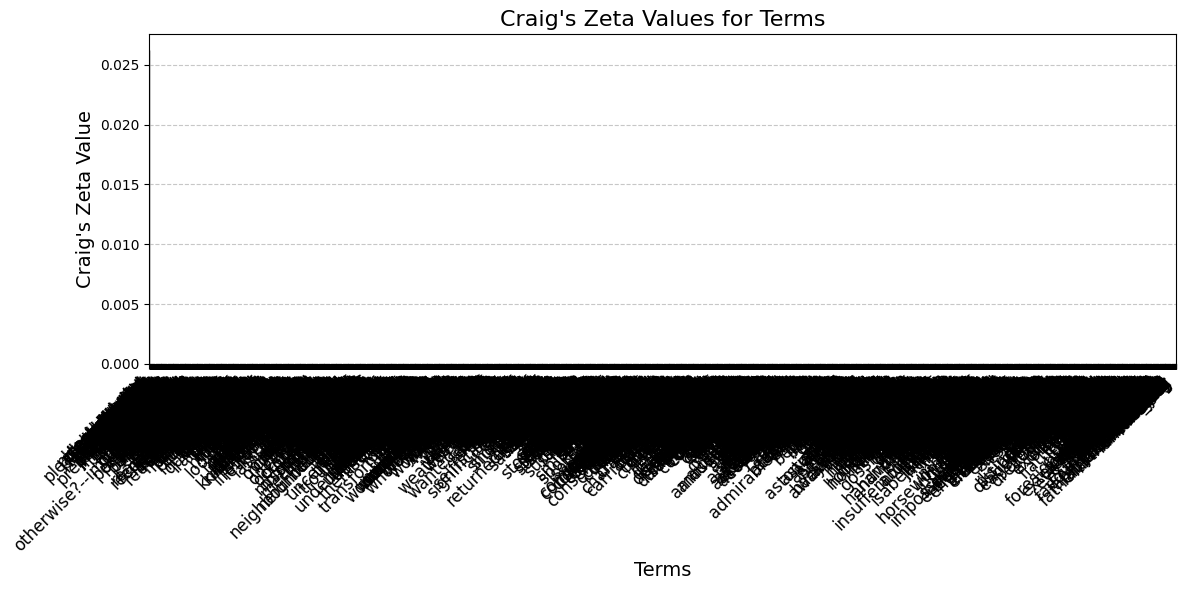

In [77]:
# Plot as a bar chart
plt.figure(figsize=(12, 6))
zeta_result.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Craig's Zeta Values for Terms", fontsize=16)
plt.xlabel("Terms", fontsize=14)
plt.ylabel("Craig's Zeta Value", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

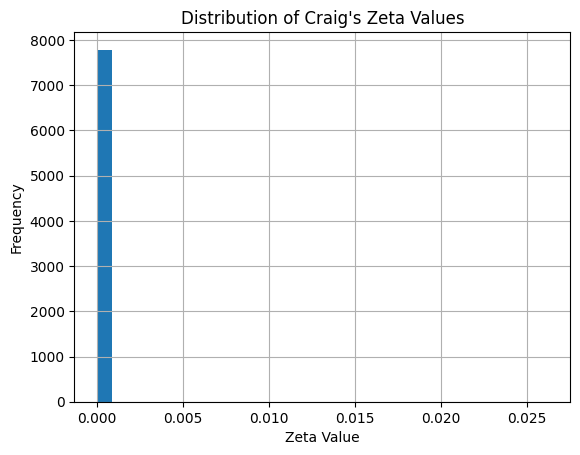

In [79]:
zeta_result.hist(bins=30)
plt.title("Distribution of Craig's Zeta Values")
plt.xlabel("Zeta Value")
plt.ylabel("Frequency") 
plt.show()


# Principal Component Analysis (PCA)

## Purpose: 
Reduce the dimensionality of text data for visualization and comparison while retaining the most significant patterns.

## Functions:
#### compute_pca: Performs PCA on a matrix of word frequencies.

## Steps:
Create a frequency matrix of terms by fileid.
Apply PCA to project the data into two dimensions.

## Visualization: 
A scatter plot shows the PCA results for easier interpretation of text similarities.

In [91]:
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

In [88]:
def compute_pca(df, feature='norm'):
    freq = (
        df.group_by(['fileid', feature])
          .agg(pl.count().alias('count'))
    )
    freq_matrix = freq.pivot(values='count', index='fileid', columns=feature, aggregate_function="sum").fill_null(0)
    freq_matrix_np = freq_matrix.drop('fileid').to_numpy()
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(freq_matrix_np)
    return reduced

In [92]:
pca_result = compute_pca(c, feature='norm')

In [93]:
pca_result 

array([[-8.28559983e+03,  2.54835445e-10],
       [ 8.28559983e+03,  2.54835445e-10]])

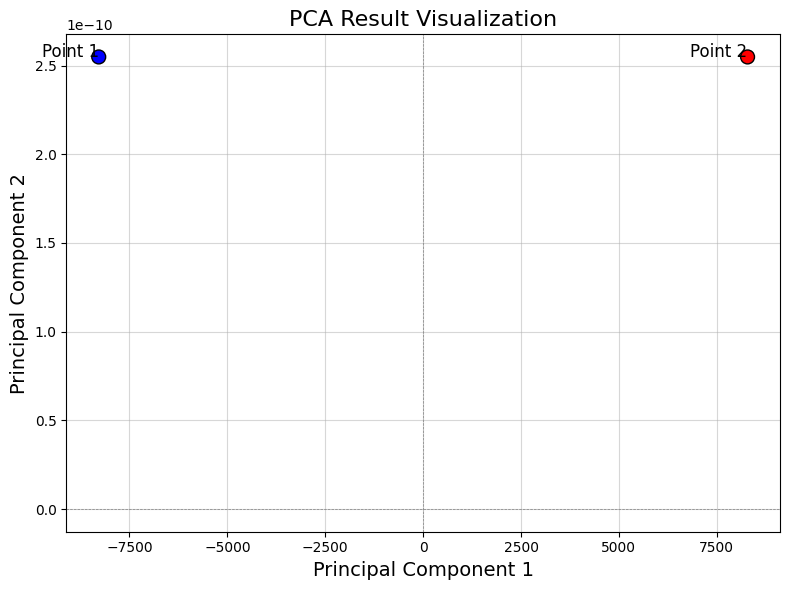

In [98]:
# Plot the PCA results
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=['blue', 'red'], s=100, edgecolor='black')
plt.title('PCA Result Visualization', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)

# Annotate points
for i, (x, y) in enumerate(pca_result):
    plt.text(x, y, f'Point {i+1}', fontsize=12, ha='right')

plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

# Rolling Delta

## Purpose: 
Analyzes changes in word frequency over rolling windows of text, capturing stylistic or thematic shifts.




## Functions:
#### rolling_delta: Computes relative word frequencies within rolling windows.
#### plot_word_frequencies: Plots trends of selected word frequencies across rolling windows.
#### plot_heatmap: Visualizes relative word frequencies as a heatmap.

## Steps:
Sort the text by sentid and segment it into rolling windows.
Compute relative frequencies of words within each window.
Store and visualize the results.

## Visualization:
Line charts for tracking word trends.
Heatmaps for comparing frequencies of multiple words across windows.

In [105]:
def rolling_delta(df, window_size=50):
    df = df.sort("sentid")
    results = []
    for group in df.group_by("fileid").groups():
        fileid = group["fileid"][0]
        norm_list = group["norm"].to_list()
        sentid_list = group["sentid"].to_list()
        for i in range(len(norm_list) - window_size + 1):
            window = norm_list[i:i + window_size]  # Extract rolling window
            start_sentid = sentid_list[i]
            end_sentid = sentid_list[i + window_size - 1]

            rel_freq = pl.DataFrame({
                "norm": window
            }).group_by("norm").count().with_column(
                (pl.col("count") / window_size)
            ).to_dict(as_series=False)

            results.append({
                "fileid": fileid,
                "start_sentid": start_sentid,
                "end_sentid": end_sentid,
                "relative_frequency": rel_freq
            })
    
    return pd.DataFrame(results)

In [106]:
rolling_result = rolling_delta(c)

In [107]:
print(rolling_result) 

             fileid      start_sentid        end_sentid  \
0       austen-emma  austen-emma_0000  austen-emma_0000   
1       austen-emma  austen-emma_0000  austen-emma_0000   
2       austen-emma  austen-emma_0000  austen-emma_0000   
3       austen-emma  austen-emma_0000  austen-emma_0000   
4       austen-emma  austen-emma_0000  austen-emma_0000   
...             ...               ...               ...   
155487  austen-emma  austen-emma_6289  austen-emma_6292   
155488  austen-emma  austen-emma_6289  austen-emma_6292   
155489  austen-emma  austen-emma_6289  austen-emma_6292   
155490  austen-emma  austen-emma_6289  austen-emma_6293   
155491  austen-emma  austen-emma_6289  austen-emma_6293   

                                       relative_frequency  
0       {',': 0.06, 'the': 0.04, 'of': 0.04, 'i': 0.04...  
1       {',': 0.06, 'of': 0.04, 'and': 0.04, 'emma': 0...  
2       {',': 0.06, 'of': 0.04, 'and': 0.04, 'emma': 0...  
3       {',': 0.06, 'and': 0.04, 'the': 0.04, 'emma

In [118]:
import seaborn as sns

In [115]:
def plot_word_frequencies(rolling_result, words, window_limit=100):
    freq_data = rolling_result.head(window_limit).copy()
    relative_freq_df = pd.DataFrame(freq_data['relative_frequency'].tolist()).fillna(0)

    freq_data = freq_data.reset_index(drop=True).join(relative_freq_df)
    
    word_frequencies = freq_data[words].reset_index(drop=True)
    word_frequencies['Window'] = word_frequencies.index
    plt.figure(figsize=(12, 6))
    
    for word in words:
        if word in word_frequencies.columns:
            plt.plot(word_frequencies['Window'], word_frequencies[word], label=word)
    
    plt.title('Relative Frequencies of Selected Words Across Rolling Windows', fontsize=16)
    plt.xlabel('Rolling Window', fontsize=14)
    plt.ylabel('Relative Frequency', fontsize=14)
    plt.legend(title='Words', fontsize=12)
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()


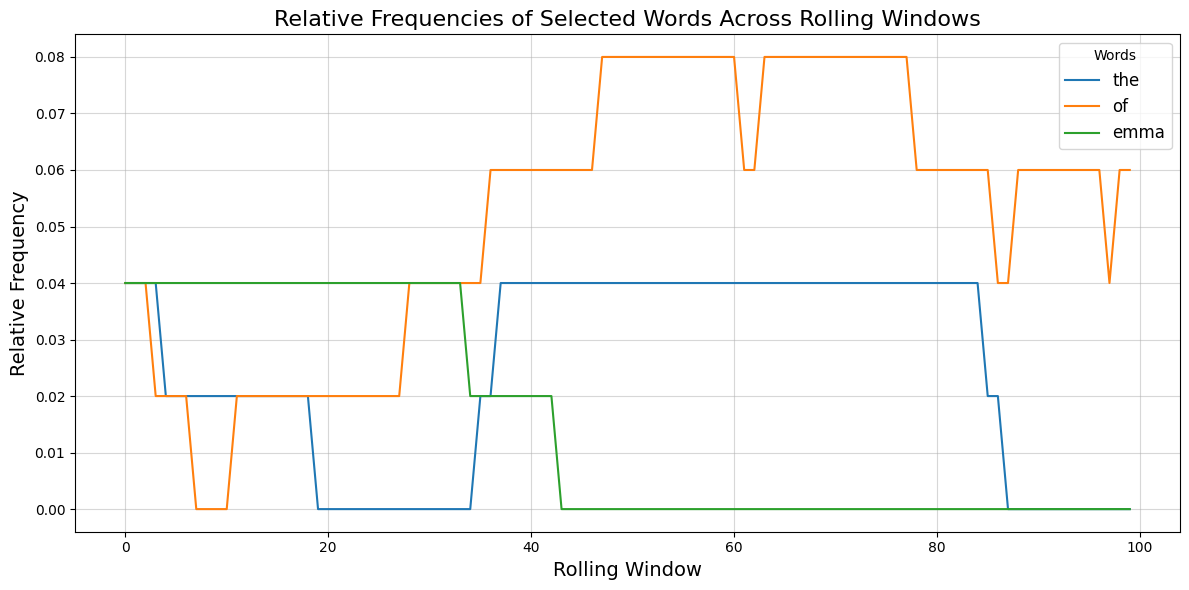

In [116]:
words_to_plot = ['the', 'of', 'emma']
plot_word_frequencies(rolling_result, words_to_plot, window_limit=100) 

In [123]:

def plot_heatmap(rolling_result, words, window_limit=10):

    freq_data = rolling_result.head(window_limit).copy()
    relative_freq_df = pd.DataFrame(freq_data['relative_frequency'].tolist()).fillna(0)

    heatmap_data = relative_freq_df[words].T  # Transpose for heatmap
    heatmap_data.columns = [f'Window {i}' for i in range(1, len(heatmap_data.columns) + 1)]
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt=".2f")
    plt.title('Heatmap of Relative Frequencies Across Rolling Windows', fontsize=16)
    plt.ylabel('Words', fontsize=14)
    plt.xlabel('Rolling Window', fontsize=14)
    plt.tight_layout()
    plt.show()

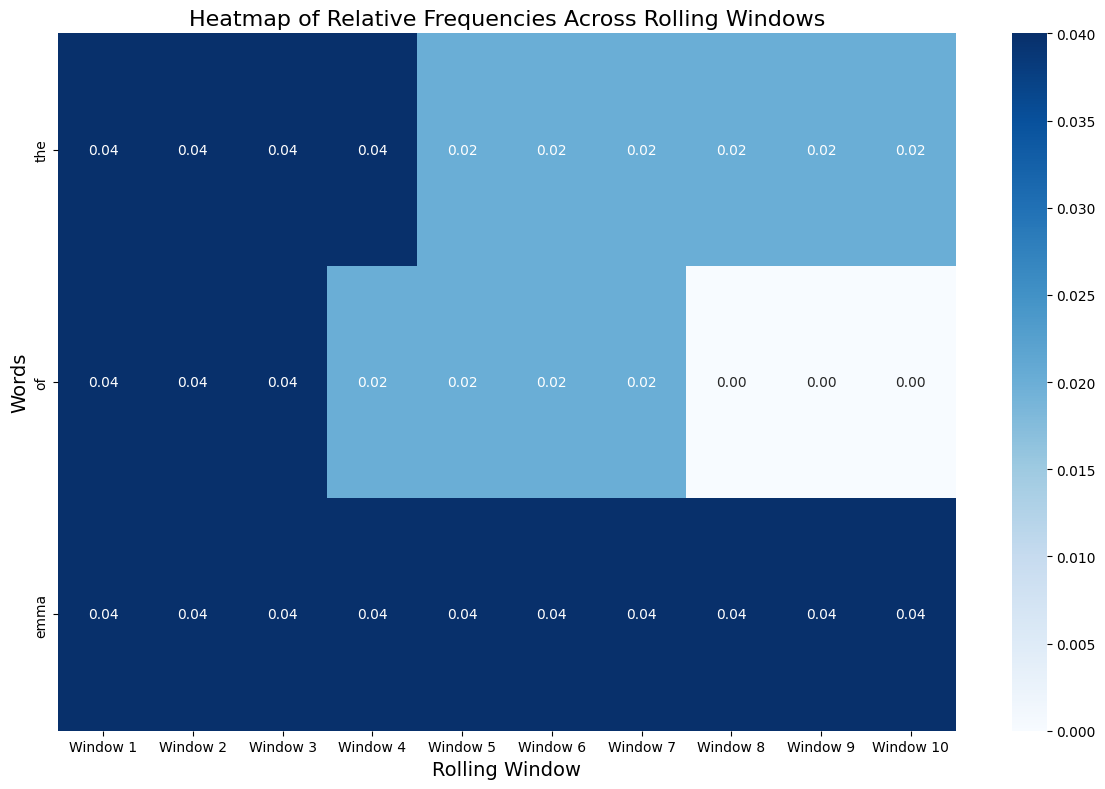

In [124]:
# Example usage
plot_heatmap(rolling_result, ['the', 'of', 'emma'], window_limit=10)